# Previsão de renda

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio

Uma instituição financeira quer conhecer melhor o perfil de renda de seus novos clientes para diversos fins, por exemplo, melhor dimensionar o limite de cartões de crédito dos novos clientes, sem necessariamente solicitar olerites ou documentações que impactem na experiência do seu cliente.

Para isto, conduziu um estudo com alguns clientes, comprovando suas rendas através de olerites e outros documentos, e pretende construir um modelo preditivo para esta renda com base em algumas variáveis que já possui em seu banco de dados.

O objetivo deste exercicío é simular um modelo real de previsão de renda e se o cliente é um bom ou mau pagador, iremos utilizar a metodologia CRISP-DM para montar o projeto.


## Etapa 2 Crisp-DM: Entendimento dos dados

A base de dados utilizada neste projeto foi disponibilizada pela EBAC no Modulo 10 do curso de ciencia de dados.

### Dicionário de dados




| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data de referência de coleta das variáveis         | object|
| id_cliente              |  Codigo identificador do cliente                                   |int|
| sexo                    |  Sexo do cliente                                      | object|
| posse_de_veiculo        |  Indica se o cliente possui veículo                                      | bool|
| posse_de_imovel         |  Indica se o cliente possui imóvel                                      | bool|
| qtd_filhos              |  Quantidade de filhos do cliente                                      | int|
| tipo_renda              |  Tipo de renda do cliente                                      | object|
| educacao                |  Grau de instrução do cliente                                      | object|
| estado_civil            |  Estado civil do cliente                                      | object|
| tipo_residencia         |  Tipo de residência do cliente (própria, alugada etc)                                     | object|
| idade                   |  Idade do cliente                                    | int|
| tempo_emprego           |  Tempo no emprego atual                                     | float|
| qt_pessoas_residencia   |  Quantidade de pessoas que moram na residência                                      | float|
| renda                   |  Indica se o cliente é mau pagador                                      | float|





#### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

#### Carregando os dados
O comando pd.read_csv é um comando da biblioteca pandas (pd.) e carrega os dados do arquivo csv indicado para um objeto *dataframe* do pandas.

In [22]:
import pandas as pd  
import seaborn as sns  
import numpy as np  
import matplotlib.pyplot as plt  
from ydata_profiling import ProfileReport  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.metrics import mean_squared_error 
from sklearn import tree 
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import io  
import re  
import statsmodels.api as sm

%matplotlib inline

In [23]:
renda = pd.read_csv('./input/previsao_de_renda.csv')

In [24]:
renda.head()

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. 

In [25]:
prof = ProfileReport(renda, explorative=True, minimal=True)
prof


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
prof.to_file('./output/renda_analisys.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Estatísticas descritivas das variáveis quantitativas

In [51]:
renda.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,15000.0,7499.500000,4330.271354,0.000000,3749.750000,7499.500000,11249.250000,14999.000000
qtd_filhos,15000.0,0.432333,0.746631,0.000000,0.000000,0.000000,1.000000,14.000000
idade,15000.0,43.882333,11.273155,22.000000,34.000000,43.000000,53.000000,68.000000
tempo_emprego,12427.0,7.722635,6.711189,0.117808,2.973973,6.013699,10.120548,42.906849
qt_pessoas_residencia,15000.0,2.206400,0.909792,1.000000,2.000000,2.000000,3.000000,15.000000
renda,15000.0,5697.287057,8266.816289,118.710000,2026.110000,3499.720000,6392.167500,245141.670000
renda_predict,15000.0,5680.278892,6430.639525,759.090000,3010.700000,3775.310000,6295.860000,150861.620000


### Entendimento dos dados - Bivariadas




#### Matriz de correlação

In [74]:
# Remover a coluna 'Unnamed: 0' se ela existir
renda = renda.loc[:, ~renda.columns.str.contains('^Unnamed')]

# Garantir que a coluna 'posse_de_imovel' seja booleana (True/False) ou numérica (0/1)
renda['posse_de_imovel'] = renda['posse_de_imovel'].map({True: 1, False: 0}).fillna(0)

# Selecionar todas as colunas numéricas
renda_numerica = renda.select_dtypes(include=['number'])

# Remover a coluna 'renda_predict', se ela existir
renda_numerica = renda_numerica.drop(columns=['renda_predict'], errors='ignore')

# Calcular a correlação entre todas as colunas numéricas
correlacao = renda_numerica.corr()

# Filtrar as correlações apenas com a 'renda'
correlacao_renda = correlacao[['renda']]

# Exibir a tabela de correlação com a 'renda'
print(correlacao_renda)

                          renda
posse_de_imovel        0.003880
qtd_filhos             0.029346
idade                  0.022435
tempo_emprego          0.385013
qt_pessoas_residencia  0.047842
renda                  1.000000


A partir da matriz de correlação, é possível observar que a variável que apresenta maior relação com a varíavel renda é tempo_emprego, com um índice de correlação de 38,5%.

#### Matriz de correlação

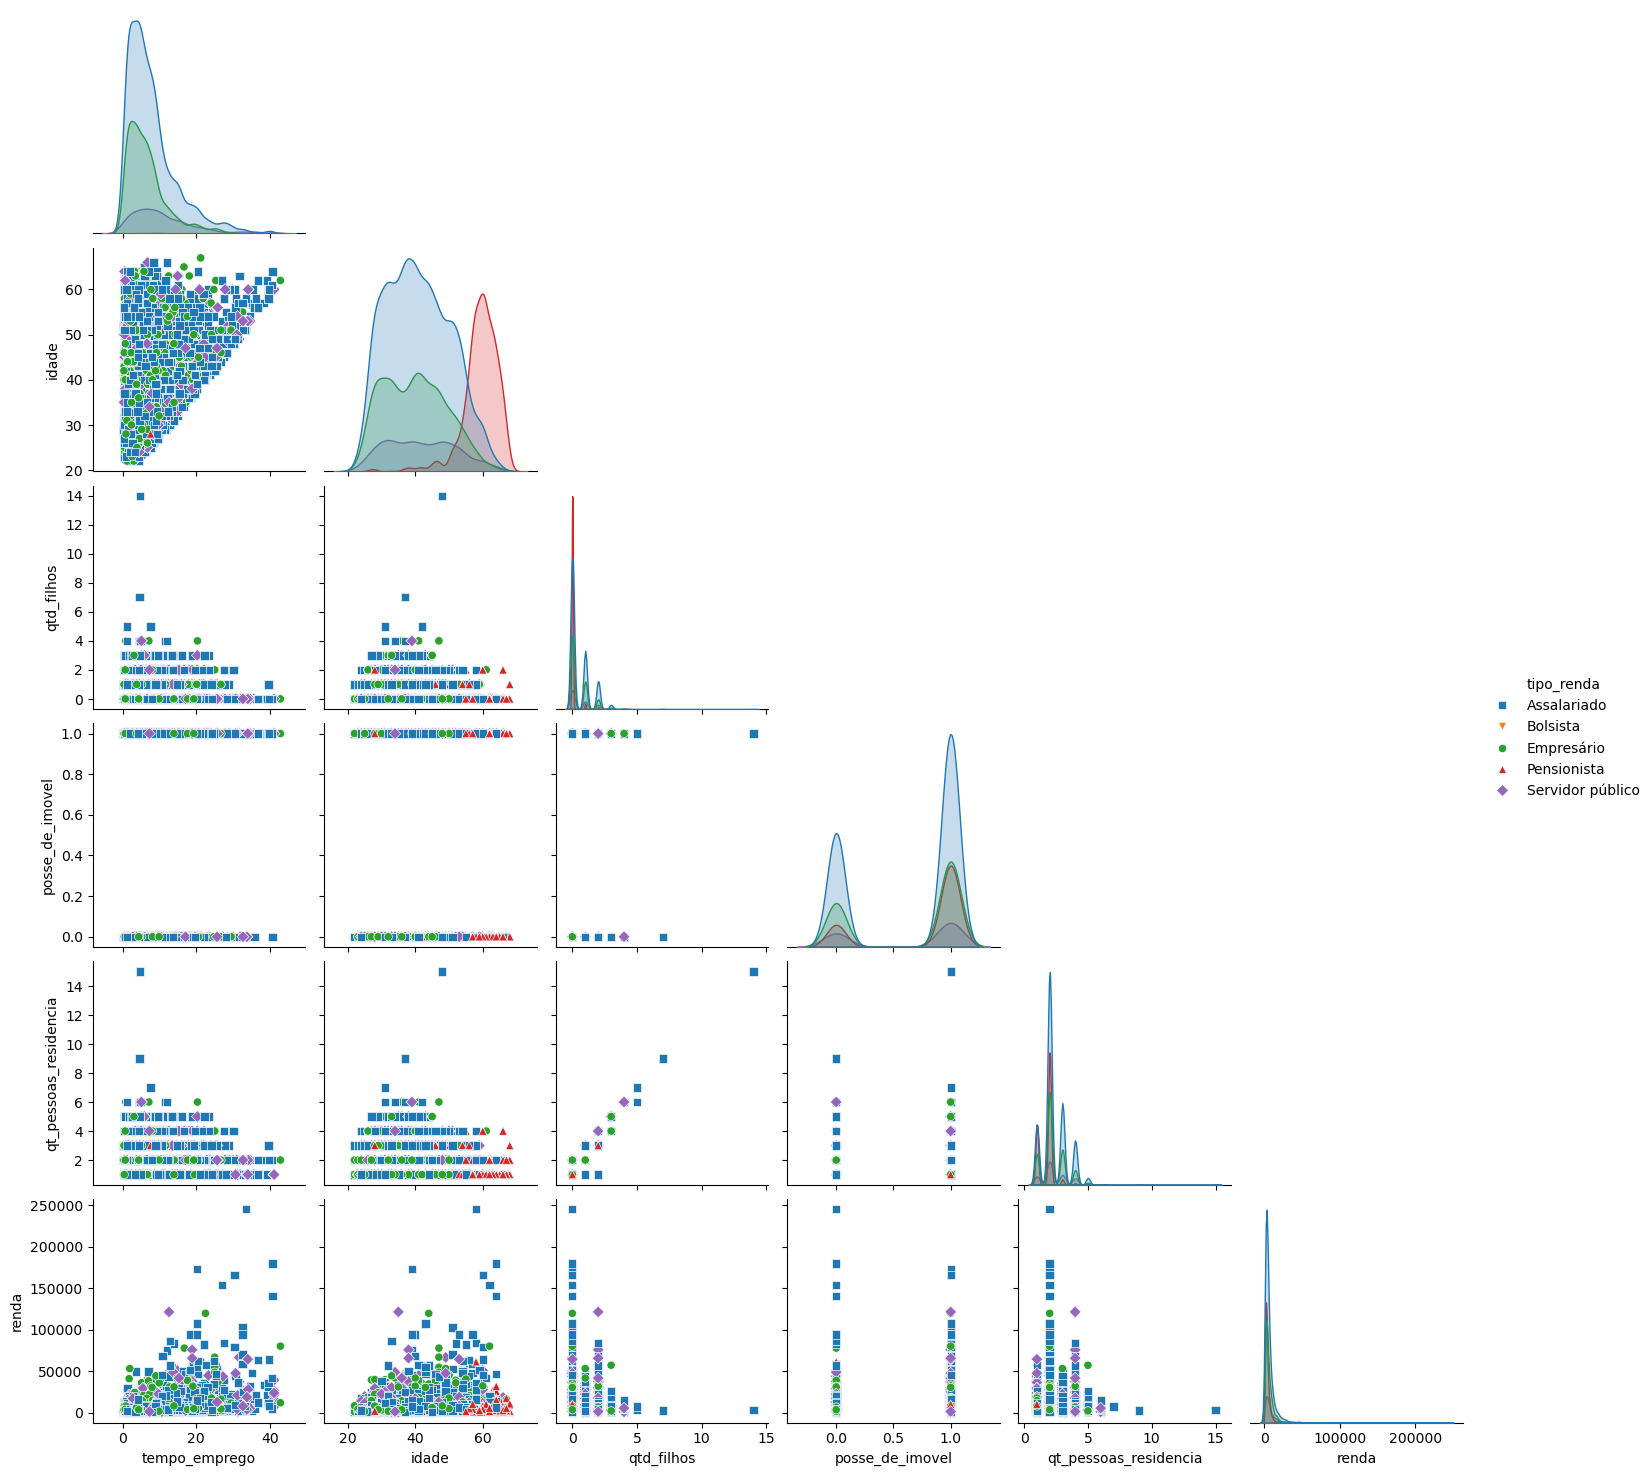

In [54]:
sns.pairplot(
    data=renda,
    hue="tipo_renda",
    hue_order=['Assalariado', 'Bolsista', 'Empresário', 'Pensionista', 'Servidor público'],
    vars=['tempo_emprego', 'idade', 'qtd_filhos', 'posse_de_imovel', 'qt_pessoas_residencia', 'renda'],
    markers=["o", "s", "D", "^", "v"],  # Adicione mais marcadores aqui
    corner=True
)

plt.show()

Ao analisar o pairplot, que consiste na matriz de dispersão, é possível identificar alguns outliers na variável renda, os quais podem afetar o resultado da análise de tendência, apesar de ocorrerem com baixa frequência. Além disso, é observada uma baixa correlação entre praticamente todas as variáveis quantitativas, reforçando os resultados obtidos na matriz de correlação.

#### Heatmap

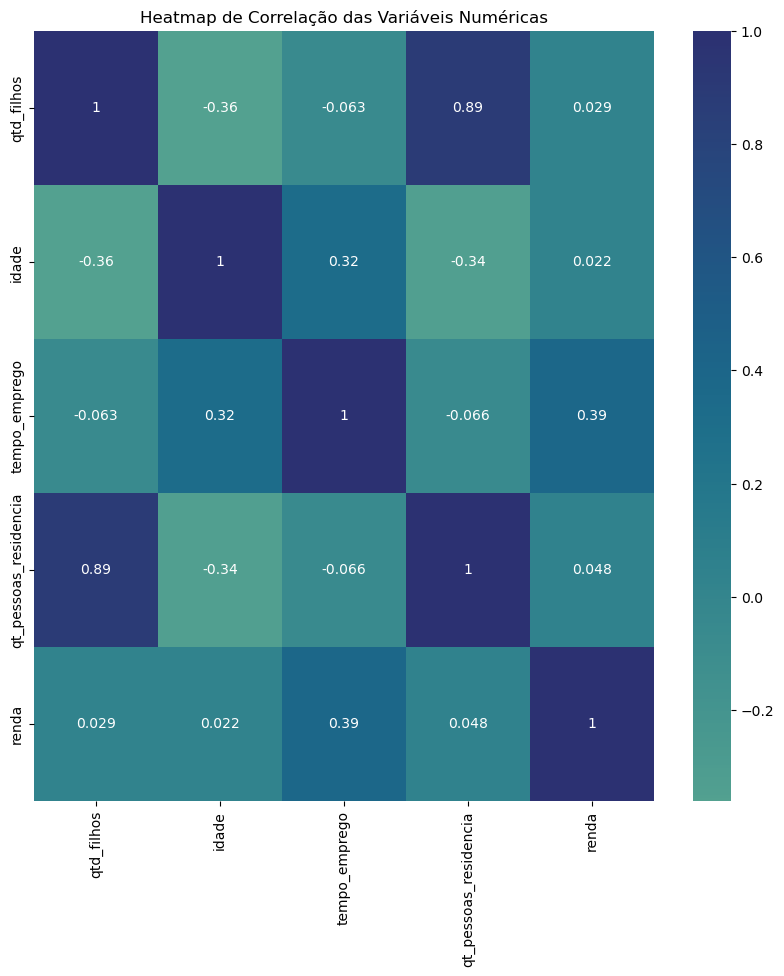

In [28]:
# Seleciona apenas colunas numéricas
renda_num = list(renda.select_dtypes(include='number').columns)

# Verifica se as colunas a serem removidas existem e as remove da lista de colunas numéricas
colunas_para_remover = ['Unnamed: 0', 'id_cliente']
colunas_para_remover = [col for col in colunas_para_remover if col in renda.columns]

# Remove as colunas indesejadas da seleção de dados numéricos
renda_num = [col for col in renda_num if col not in colunas_para_remover]

# Criar o gráfico de heatmap
plt.figure(figsize=(10, 10))
plt.title('Heatmap de Correlação das Variáveis Numéricas')

# Gerar e exibir o heatmap de correlação
sns.heatmap(
    renda[renda_num].corr(),
    annot=True,
    center=0,
    cmap='crest'
)

# Exibir o gráfico
plt.show()

Com o heatmap, é possível reforçar novamente os resultados de baixa correlação com a variável renda.

#### Linha de tendência

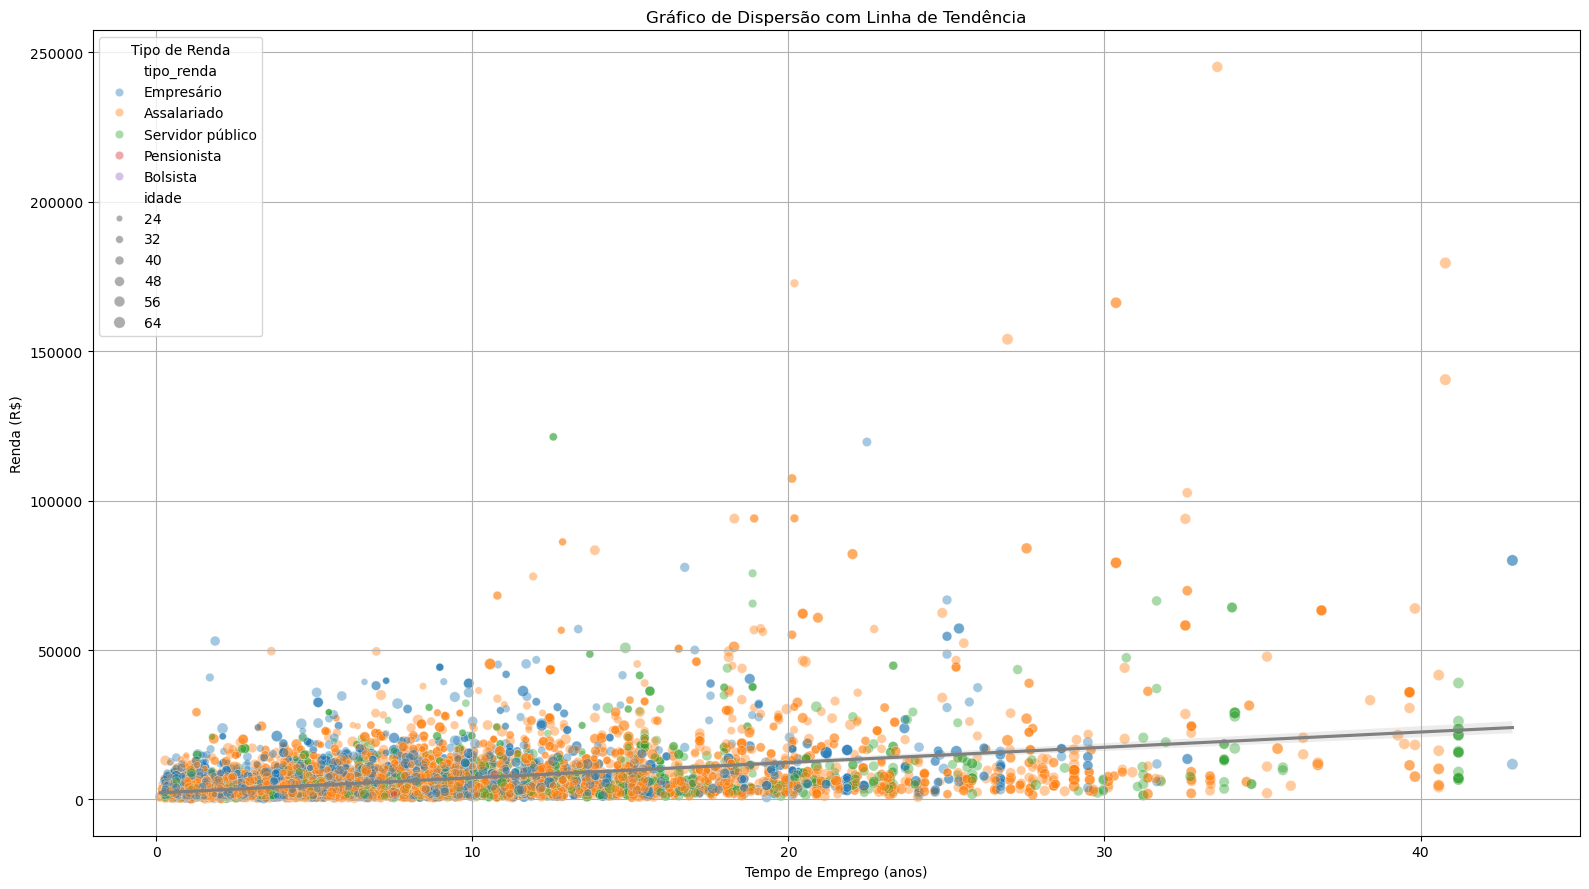

In [77]:
# Definir o tamanho padrão para os gráfico
plt.figure(figsize=(16,9))

sns.scatterplot(
    x='tempo_emprego',
    y='renda', 
    hue='tipo_renda', 
    size='idade',
    data=renda,
    alpha=0.4
)

sns.regplot(
    x='tempo_emprego', 
    y='renda', 
    data=renda, 
    scatter=False, 
    color='gray'
)

plt.title('Gráfico de Dispersão com Linha de Tendência')
plt.xlabel('Tempo de Emprego (anos)')
plt.ylabel('Renda (R$)')
plt.legend(title='Tipo de Renda')
plt.grid(True)
plt.tight_layout()


plt.show()

#### Análise da distribuição da variável renda em função da variável tempo_emprego:

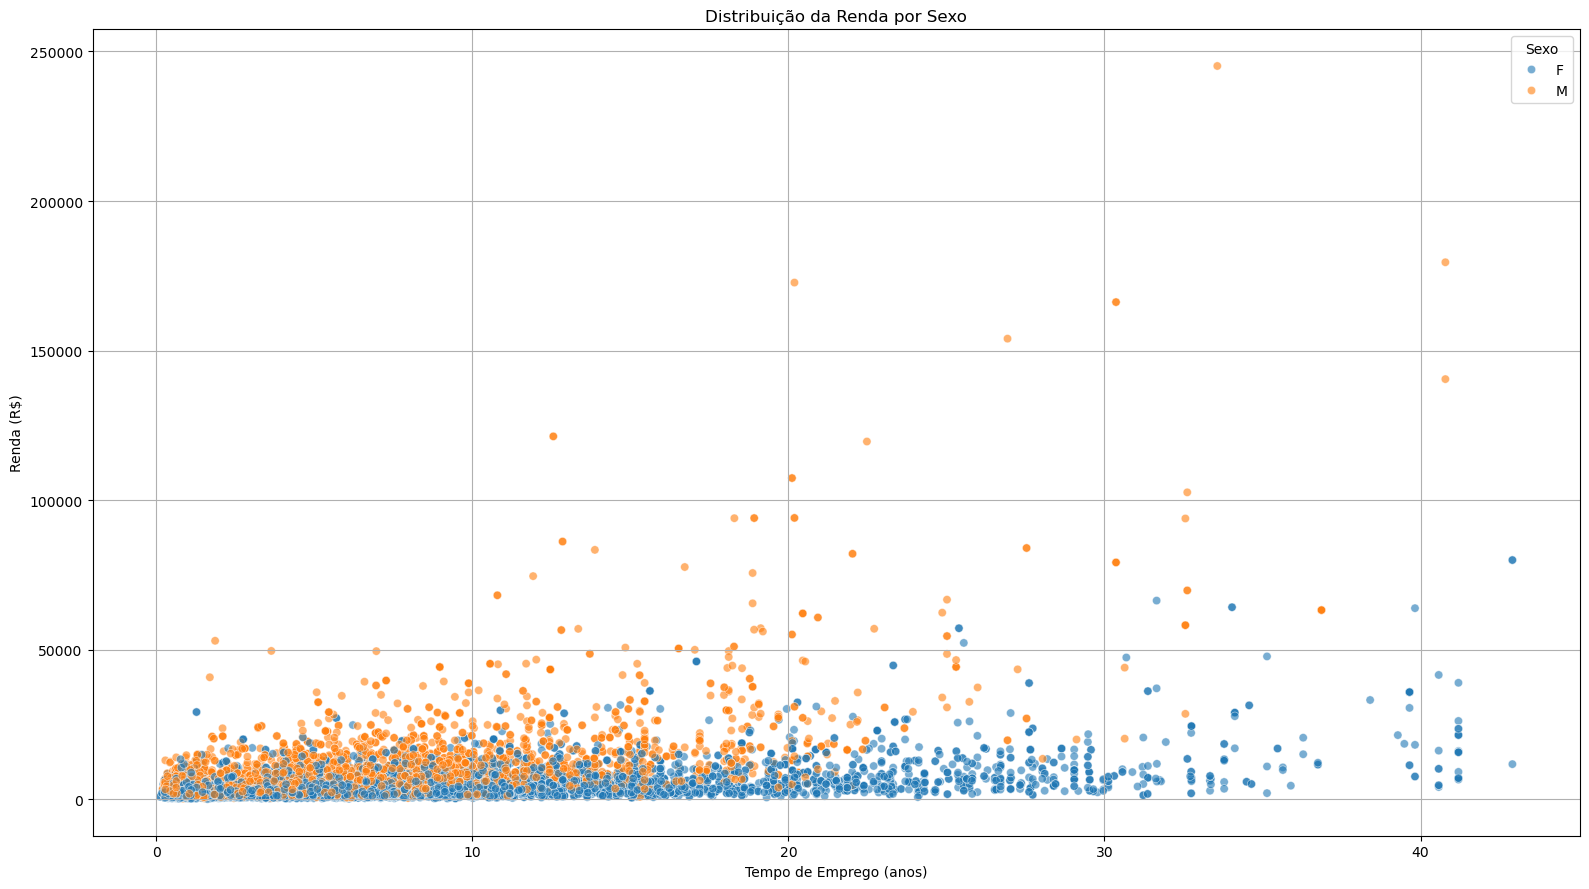

In [78]:
# Definir o tamanho padrão para os gráfico
plt.figure(figsize=(16,9))

sns.scatterplot(
    data=renda, 
    x='tempo_emprego', 
    y='renda', 
    hue='sexo',
    alpha=0.6
)

plt.title('Distribuição da Renda por Sexo')
plt.xlabel('Tempo de Emprego (anos)')
plt.ylabel('Renda (R$)')
plt.legend(title='Sexo')
plt.grid(True)
plt.tight_layout()

# Exibir o segundo gráfico
plt.show()

#### Análise das variáveis categóricas em relação a renda

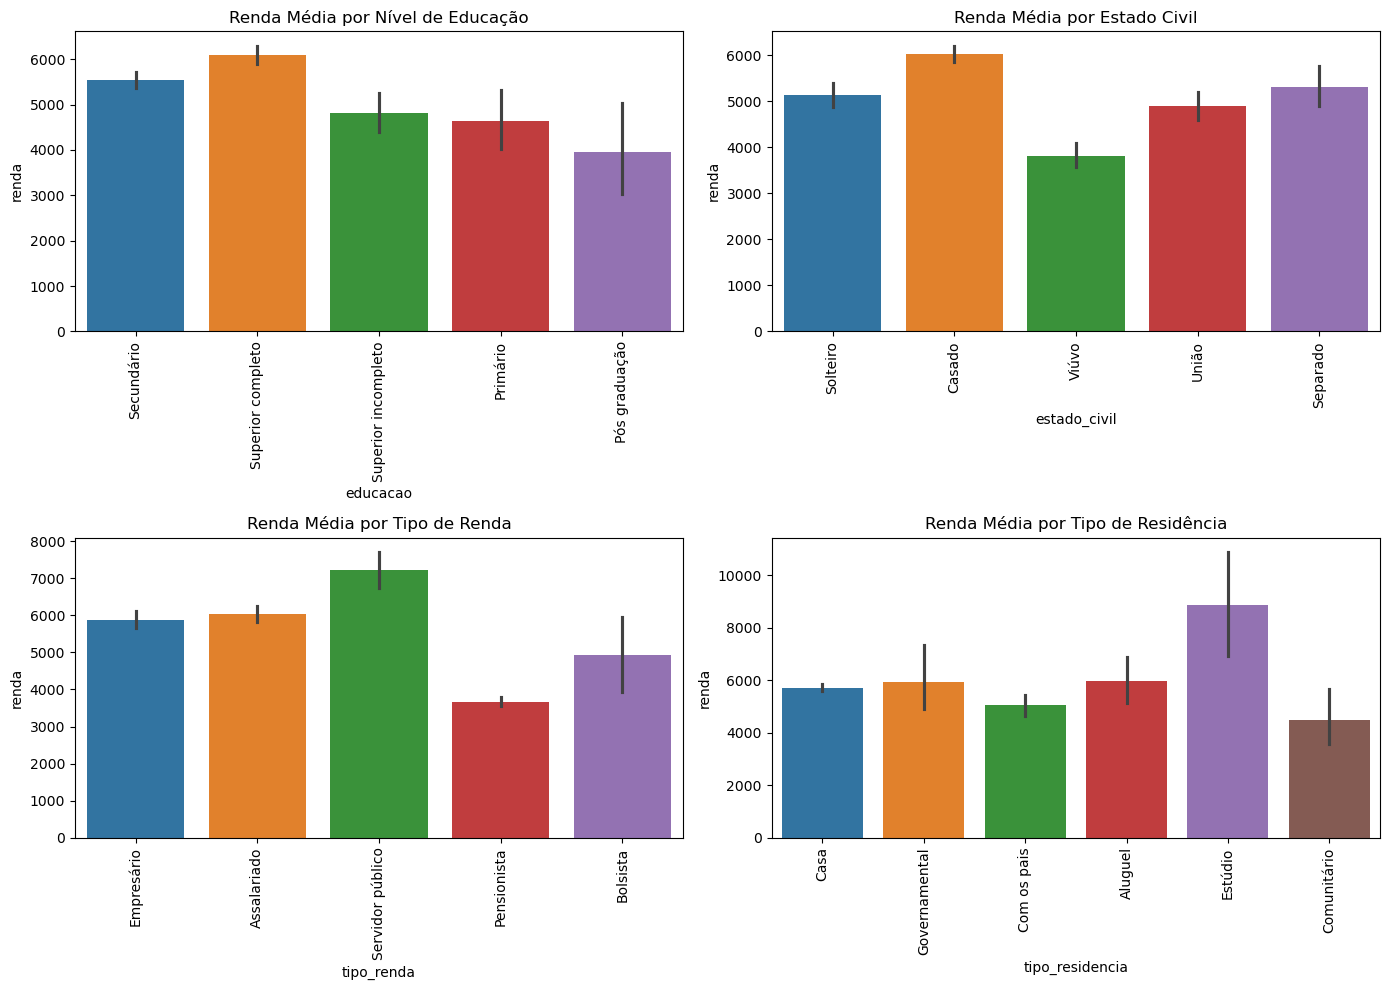

In [79]:
# Calculando a média da renda
renda_media = renda['renda'].mean()

# Gráficos adicionais com layout em grade
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Renda Média por Nível de Educação
sns.barplot(
    x="educacao", y="renda", data=renda, ax=axes[0, 0], hue="educacao", dodge=False
)
axes[0, 0].set_title("Renda Média por Nível de Educação")
axes[0, 0].tick_params(axis='x', rotation=90)

# Gráfico 2: Renda Média por Estado Civil
sns.barplot(
    x="estado_civil", y="renda", data=renda, ax=axes[0, 1], hue="estado_civil", dodge=False
)
axes[0, 1].set_title("Renda Média por Estado Civil")
axes[0, 1].tick_params(axis='x', rotation=90)

# Gráfico 3: Renda Média por Tipo de Renda
sns.barplot(
    x="tipo_renda", y="renda", data=renda, ax=axes[1, 0], hue="tipo_renda", dodge=False
)
axes[1, 0].set_title("Renda Média por Tipo de Renda")
axes[1, 0].tick_params(axis='x', rotation=90)

# Gráfico 4: Renda Média por Tipo de Residência
sns.barplot(
    x="tipo_residencia", y="renda", data=renda, ax=axes[1, 1], hue="tipo_residencia", dodge=False
)
axes[1, 1].set_title("Renda Média por Tipo de Residência")
axes[1, 1].tick_params(axis='x', rotation=90)

# Ajustar o layout para que os gráficos não sobreponham
plt.tight_layout()

# Exibir os gráficos
plt.show()

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



In [31]:
renda.drop(columns=['data_ref', 'id_cliente'], axis=1, inplace=True)

In [32]:
renda.head()

,Unnamed: 0,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


In [24]:
#Verificando se há dados faltantes em nossa base de dados, podemos verificar que não há
renda.isna().value_counts()

Unnamed: 0  sexo   posse_de_veiculo  posse_de_imovel  qtd_filhos  tipo_renda  educacao  estado_civil  tipo_residencia  idade  tempo_emprego  qt_pessoas_residencia  renda
False       False  False             False            False       False       False     False         False            False  False          False                  False    12427
                                                                                                                              True           False                  False     2573
Name: count, dtype: int64

In [33]:
renda_dummies = pd.get_dummies(data=renda)
renda_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     15000 non-null  int64  
 1   posse_de_veiculo               15000 non-null  bool   
 2   posse_de_imovel                15000 non-null  bool   
 3   qtd_filhos                     15000 non-null  int64  
 4   idade                          15000 non-null  int64  
 5   tempo_emprego                  12427 non-null  float64
 6   qt_pessoas_residencia          15000 non-null  float64
 7   renda                          15000 non-null  float64
 8   sexo_F                         15000 non-null  bool   
 9   sexo_M                         15000 non-null  bool   
 10  tipo_renda_Assalariado         15000 non-null  bool   
 11  tipo_renda_Bolsista            15000 non-null  bool   
 12  tipo_renda_Empresário          15000 non-null 

In [37]:
(renda_dummies.corr()['renda']
              .sort_values(ascending=False)
              .to_frame()
              .reset_index()
              .rename(columns={'index':'var', 
                               'renda':'corr'})
              .style.bar(color=['red', 'lightgreen'], align=0)
)

,var,corr
0,renda,1.000000
1,tempo_emprego,0.385013
2,sexo_M,0.285076
3,posse_de_veiculo,0.100493
4,estado_civil_Casado,0.062337
5,tipo_renda_Servidor público,0.056176
6,qt_pessoas_residencia,0.047842
7,tipo_renda_Assalariado,0.042594
8,educacao_Superior completo,0.036099
9,qtd_filhos,0.029346


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


In [80]:
# Pré-processamento dos dados
categorical_columns = renda.select_dtypes(include=['object']).columns.tolist()
print("Colunas categóricas identificadas:", categorical_columns)

# Convertendo colunas categóricas em variáveis dummies
renda_dummies = pd.get_dummies(renda, columns=categorical_columns, drop_first=True)

# Definindo as variáveis X e y
X = renda_dummies.drop(['renda'], axis=1).copy()
y = renda_dummies['renda']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Treinamento do Modelo 1: Random Forest com profundidade máxima 2
modelo_1 = RandomForestRegressor(max_depth=2, random_state=42)
modelo_1.fit(X_train, y_train)

# Treinamento do Modelo 2: Random Forest com profundidade máxima 8
modelo_2 = RandomForestRegressor(max_depth=8, random_state=42)
modelo_2.fit(X_train, y_train)

# Calculando o R² para os dois modelos
mse1 = modelo_1.score(X_test, y_test)
mse2 = modelo_2.score(X_test, y_test)

print(f"O R² do modelo 1 (max_depth=2) é {mse1:.4f}")
print(f"O R² do modelo 2 (max_depth=8) é {mse2:.4f}")

Colunas categóricas identificadas: ['sexo', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
O R² do modelo 1 (max_depth=2) é 0.2922
O R² do modelo 2 (max_depth=8) é 0.3286


In [81]:
# Ajustando o Modelo 2 com parâmetros adicionais
modelo_2 = RandomForestRegressor(max_depth=8, min_samples_leaf=4, random_state=42)
modelo_2.fit(X_train, y_train)
mse1 = modelo_2.score(X_test, y_test)

print(f"O R² do modelo 2 ajustado (max_depth=8, min_samples_leaf=4) é {mse1:.4f}")

O R² do modelo 2 ajustado (max_depth=8, min_samples_leaf=4) é 0.3397


### Rodando o modelo


#### Visualização gráfica da árvore com plot_tree

Treinando e visualizando um modelo de DecisionTreeRegressor...
O R² do modelo DecisionTreeRegressor (max_depth=8, min_samples_leaf=4) é 0.2533


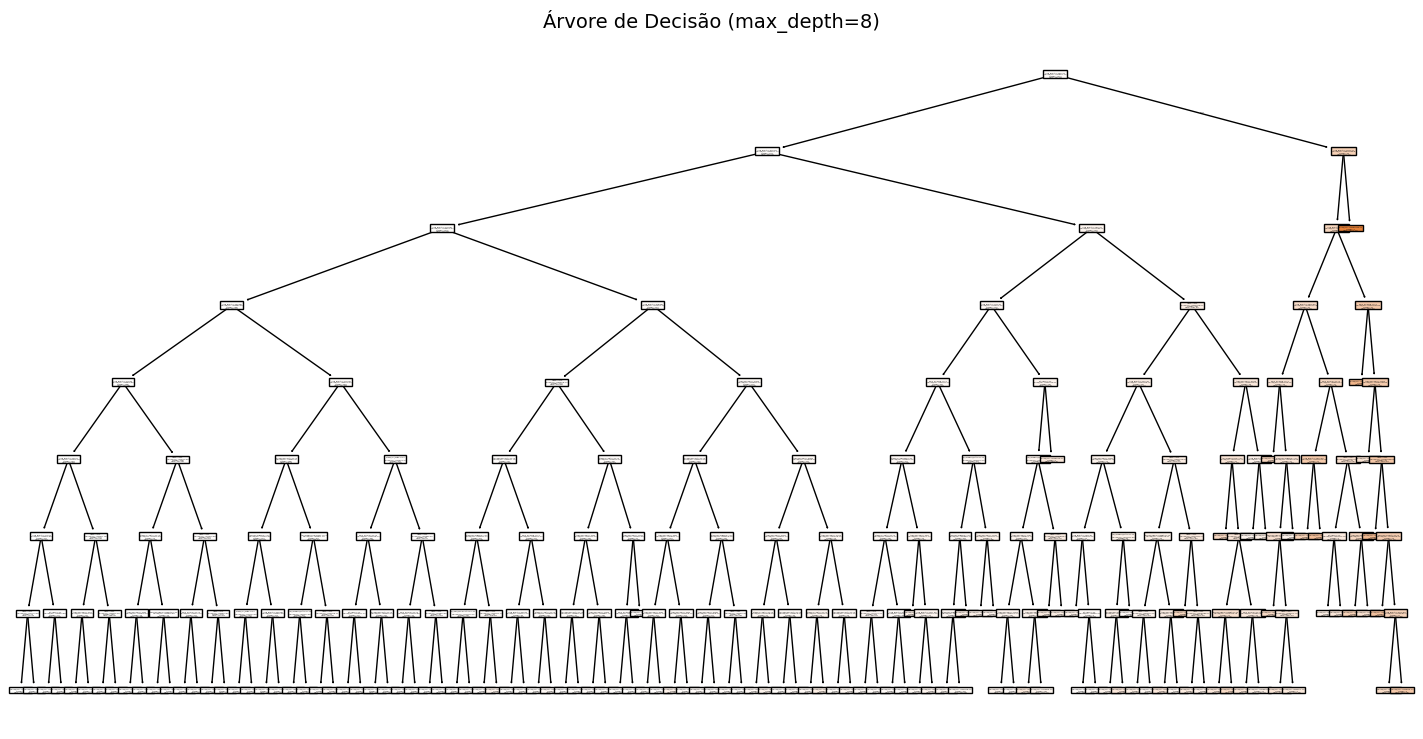

In [82]:
# Treinamento e visualização do modelo de DecisionTreeRegressor
print("Treinando e visualizando um modelo de DecisionTreeRegressor...")
modelo_dt = DecisionTreeRegressor(max_depth=8, min_samples_leaf=4, random_state=42)
modelo_dt.fit(X_train, y_train)

# Avaliação do modelo
r2_dt = modelo_dt.score(X_test, y_test)
print(f"O R² do modelo DecisionTreeRegressor (max_depth=8, min_samples_leaf=4) é {r2_dt:.4f}")

# Visualizando a árvore de decisão
fig, ax = plt.subplots(figsize=(18, 9))
plot_tree(modelo_dt, feature_names=X.columns, filled=True)
plt.title("Árvore de Decisão (max_depth=8)", fontsize=14)
plt.show()

#### Teste da melhor profundidade e do número mínimo de amostras por folha da árvore:

Iniciando otimização de parâmetros...


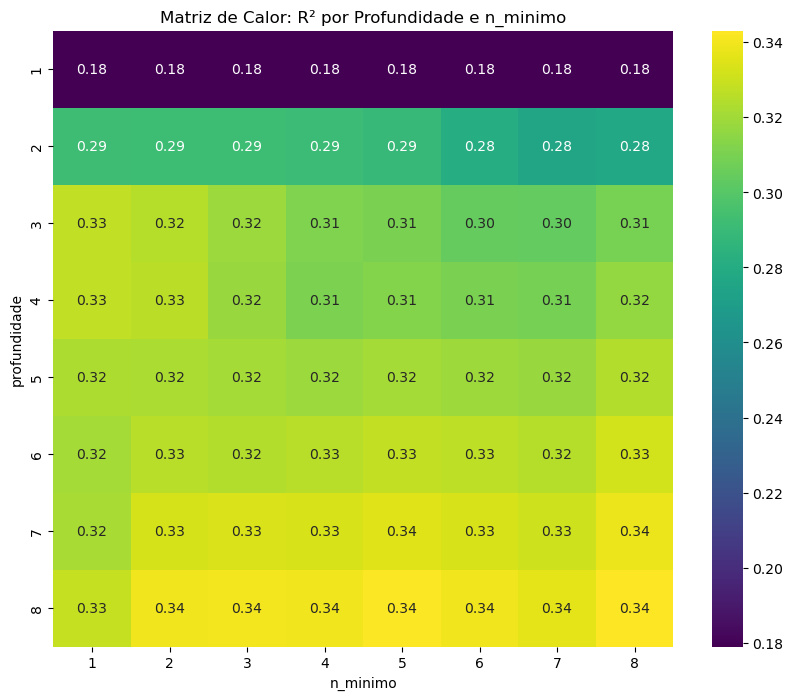

In [83]:
# Otimização de parâmetros (max_depth e min_samples_leaf)
r2s = []
i_indicador = []
j_indicador = []

print("Iniciando otimização de parâmetros...")
for i in range(1, 9):
    for j in range(1, 9):
        modelo_2 = RandomForestRegressor(max_depth=i, min_samples_leaf=j, random_state=42)
        modelo_2.fit(X_train, y_train)
        r2_1 = modelo_2.score(X_test, y_test)
        r2s.append(r2_1)
        i_indicador.append(i)
        j_indicador.append(j)

# Criando o DataFrame para R²
renda_r2 = pd.DataFrame({'r2': r2s, 'profundidade': i_indicador, 'n_minimo': j_indicador})

# Criando a matriz de calor (heatmap)
fig, ax = plt.subplots(figsize=(10, 8))
pivot_table = renda_r2.pivot(index='profundidade', columns='n_minimo', values='r2')
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.2f', ax=ax)
ax.set_title('Matriz de Calor: R² por Profundidade e n_minimo')
plt.show()

In [84]:
# Configuração para Grid Search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 1000],
}   

# Criação do modelo inicial
rf = RandomForestRegressor(max_depth=7, min_samples_leaf=7, random_state=42)

# Realização do grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_

print("Melhor modelo encontrado pelo GridSearchCV:")
print(best_model)

Melhor modelo encontrado pelo GridSearchCV:
RandomForestRegressor(max_depth=7, min_samples_leaf=7, n_estimators=1000,
                      random_state=42)


In [85]:
# Ajustando o modelo final com os melhores parâmetros
modelo_final = RandomForestRegressor(max_depth=7, min_samples_leaf=7, n_estimators=500, random_state=42)
modelo_final.fit(X_train, y_train)

# Previsões do modelo final
y_pred = modelo_final.predict(X_test)

# Exibindo o R² do modelo final
r2_final = modelo_final.score(X_test, y_test)
print(f"O R² do modelo final (max_depth=7, min_samples_leaf=7, n_estimators=500) é {r2_final:.4f}")

# Exibindo os primeiros resultados de previsões
resultados = pd.DataFrame({'Real': y_test, 'Previsto': y_pred})
print("Primeiros resultados das previsões:")
print(resultados.head(10))

# Métricas adicionais
index = ['r_squared', 'mean_absolute_error', 'root_mean_squared_error']

O R² do modelo final (max_depth=7, min_samples_leaf=7, n_estimators=500) é 0.3338
Primeiros resultados das previsões:
           Real      Previsto
11499   3479.22   3026.262280
6475    4867.69   2725.888535
13167  23610.27  20011.169037
862      707.96   2735.230791
5970    4349.39   6725.517253
6706   15289.23   3564.531231
3017    1918.32   4150.624640
3781    3724.31  10094.398646
3898    1281.22   2972.881982
2250    5746.69   4204.664004


In [86]:
hiperpametros = pd.DataFrame({'conjunto_treino': r2_score(y_train, modelo_final.predict(X_train))}, index=index)
hiperpametros.loc['mean_absolute_error', 'conjunto_treino'] = mean_absolute_error(y_train, modelo_final.predict(X_train))
hiperpametros.loc['root_mean_squared_error', 'conjunto_treino'] = mean_squared_error(y_train, modelo_final.predict(X_train)) ** 0.5
hiperpametros['conjunto_teste'] = r2_score(y_test, modelo_final.predict(X_test))
hiperpametros.loc['mean_absolute_error', 'conjunto_teste'] = mean_absolute_error(y_test, modelo_final.predict(X_test))
hiperpametros.loc['root_mean_squared_error', 'conjunto_teste'] = mean_squared_error(y_test, modelo_final.predict(X_test)) ** 0.5

print("Métricas finais:")
print(hiperpametros)

Métricas finais:
                         conjunto_treino  conjunto_teste
r_squared                       0.621988        0.333790
mean_absolute_error          2820.179092     3079.415319
root_mean_squared_error      5259.176430     5713.525195


## Etapa 5 Crisp-DM: Avaliação dos resultados


In [87]:
# Avaliação da árvore de regressão
r2_train = modelo_dt.score(X=X_train, y=y_train)
r2_test = modelo_dt.score(X=X_test, y=y_test)

template = 'O coeficiente de determinação (𝑅2) da árvore com profundidade = {0} para a base de {1} é: {2:.2f}'

print(template.format(modelo_dt.get_depth(), 'treino', r2_train).replace(".", ","))
print(template.format(modelo_dt.get_depth(), 'teste', r2_test).replace(".", ","), '\n')

O coeficiente de determinação (𝑅2) da árvore com profundidade = 8 para a base de treino é: 0,65
O coeficiente de determinação (𝑅2) da árvore com profundidade = 8 para a base de teste é: 0,25 



In [88]:
renda['renda_predict'] = np.round(modelo_dt.predict(X), 2)
renda[['renda', 'renda_predict']]

,renda,renda_predict
0,8060.34,3042.84
1,1852.15,9860.40
2,2253.89,2885.76
3,6600.77,2822.58
4,6475.97,4605.93
...,...,...
14995,7990.58,4668.19
14996,10093.45,3525.31
14997,604.82,3525.31
14998,3352.27,4618.71


## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

### Simulando a previsão de renda

In [90]:
# Foi criado as variáveis dummies para a entrada
entrada_dummies = pd.get_dummies(entrada)

# Em seguida, as colunas foram alinhadas para que correspondam exatamente às do conjunto de treinamento
entrada_alinhada = entrada_dummies.reindex(columns=X.columns, fill_value=0)

# Previsão com o modelo de árvore de decisão
renda_estimada = modelo_dt.predict(entrada_alinhada).item()

# Exibindo o resultado
print(f"Renda estimada: R${str(np.round(renda_estimada, 2)).replace('.', ',')}")


Renda estimada: R$1615,26
